<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0719/04_2(solution)YOLOv4_inference_on_Webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4_inference on Webcam

해당 코드는 theAIGuysCode의 github repository를 참고하여 제작되었습니다.

링크: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

## 0) git clone

`git clone [git repo url] (local dir)`

* 주소를 입력한 Git repository의 가장 최신 버전을 복제한다.
* repository는 프로젝트 코드를 저장하는 가상 저장공간이다.
* git repo url에는 클로닝하고자 하는 repository의 주소를 입력한다.

주소 예시)

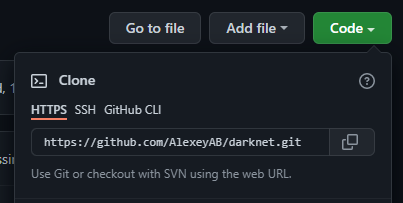
* local dir에는 복제본의 저장위치를 지정한다. (생략 가능)

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15530, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15530 (delta 6), reused 10 (delta 4), pack-reused 15514
Receiving objects: 100% (15530/15530), 14.22 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (10418/10418), done.


## 1) train에 사용된 파일 업로드

* 로컬 저장소에서 직접 업로드하거나, 구글 드라이브에서 직접 다운로드하는 방법이 있다.
* 파일 용량이 클 경우 구글 드라이브에서 다운로드하는 방법이 더 빠르다.

In [ ]:
# 업로드할 디렉토리로 이동
%cd /content/darknet/data

/content/darknet/data


* gdown 뒤에 파일 아이디를 입력한다.
* 파일아이디는 파일 링크에서 d와 view 사이에 있는 문자에 해당한다.

In [ ]:
!pip install -U --no-cache-dir gdown --pre

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
# train.txt
!gdown --id 12RcMEmicVMyHkxd14SBlRLTXoHmlmwT3

# test.txt
!gdown --id 15xO2ZoauvXj-UUKLciQ61MEwlO99-c1r

# valid.txt
!gdown --id 1oxT7r8g16k8BEZdZq1hdMETfefuDISpe

# ClassNames
!gdown --id 1Ea9iydXmibS1bDnlVRsPhK4E9r-yifyT

# mask_data.data
!gdown --id 1UsmZzSrupC28Fewv1AXrv-kvxHhFbT-N

# yolov4-custom_best.weights
!gdown --id 1wH9_mWifhShaK5LlVvRq3DKLtkLU3et9

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12RcMEmicVMyHkxd14SBlRLTXoHmlmwT3
To: /content/darknet/data/train.txt
100% 10.4k/10.4k [00:00<00:00, 40.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15xO2ZoauvXj-UUKLciQ61MEwlO99-c1r
To: /content/darknet/data/test.txt
100% 1.58k/1.58k [00:00<00:00, 8.34MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https:

## 2) .cfg 파일 수정

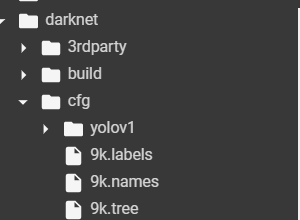

* darknet 폴더 아래 cfg 폴더를 클릭 -> yolo4-custom 더블 클릭

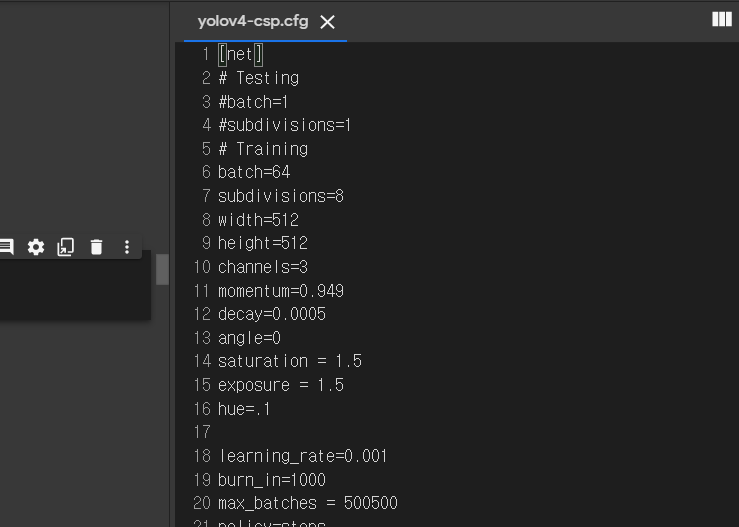

* cfg 파일을 더블클릭하면 파일 내용을 편집/탐색할 수 있도록 사이드에 파일이 열린다.

다음과 같이 yolo4-custom.cfg 파일을 수정한다.
* subdivision = 16
* width = 416
* height = 416
* max_batches = num_classes * 2000 = 2 * 2000 = 4000
* steps = max_batches * 0.8, max_batches * 0.9 = 3200, 3600
* yolo layer 마다 classes=2
* yolo layer 앞에 있는 convolutional layer 마다 filers = (num_classes + 5) * 3 = 21

In [ ]:
# 변경사항이 반영이 되었는지 확인하여보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=1
subdivisions=1
width=416
height=416
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=

* 하지만 train과 달리 test를 위해서는 batch와 subdivisions를 다르게 수정해야 한다.
* 이번에는 명령어를 사용하여 cfg를 수정하여 보자.

`!sed [옵션] '명령어' [파일] `
* sed는 리눅스 os에서 비대화형 모드로 [파일]에 해당하는 텍스트 파일을 편집한다.

`-i`
* inplace로 명령어를 수행하는 옵션이다.
* -i.back으로 옵션을 설정할 경우 오리지널 파일의 백업 데이터가 생성된다.

`'s/검색할 문자열/치환할 문자열'`
* s(=subsitute command)는 치환을 수행하는 명령어이다.
* [파일]에서 조건에 일치하는 문자열을 모두 찾아 치환할 문자열로 대체한다.

In [ ]:
#set your custom cfg to test mode
%cd /content/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
%cat /content/darknet/data/mask_data.data

classes = 2
train = /content/darknet/data/train.txt
valid = /content/darknet/data/valid.txt
test = /content/darknet/data/test.txt
names = /content/darknet/data/ClassNames.names
backup = /content/darknet/backup/

## 3) darknet 구축(컴파일)

* 기존 파일을 그대로 사용하는 것이 아니라 Makefile을 수정하여 옵션을 변경하여 보자.
* Makefile은 darknet 프로젝트 폴더 내에 존재하며, darknet 구축을 위한 옵션이 저장되어 있다.

(변경 전)

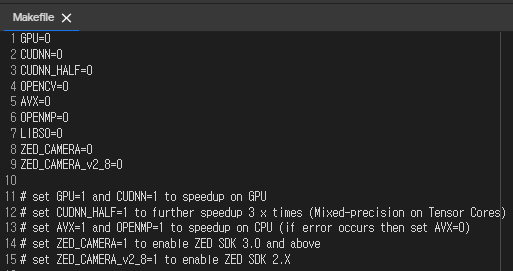

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!pwd

/content/darknet


In [ ]:
# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

(변경 후)

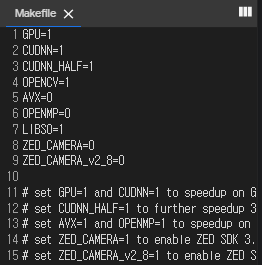

* darknet을 구축하여보자.
* !make로 Makefile을 컴파일할 수 있다.

In [ ]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |  

## 4) load network & darknet helper

파이썬 코드로 YOLO ver 4을 사용하기 위해서는 darknet에서 찾을 수 있는 사전에 구축된 function들을 사용할 것이다. function들을 import하여보자.


In [ ]:
!pwd

/content/darknet


In [ ]:
from darknet import *

In [ ]:
# YOLOv4 모델을 로드하여보자.
# 커스텀 모델을 사용할 경우 load_network의 1번째, 3번째 인자를 수정해야 한다.
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/mask_data.data", "data/yolov4-custom_best.weights")

    (참고)
    .cfg 파일은 다양한 프로그램 환경에서 각자의 소프트웨어에 특정한 설정을 저장하는 데 사용되는 파일 형식

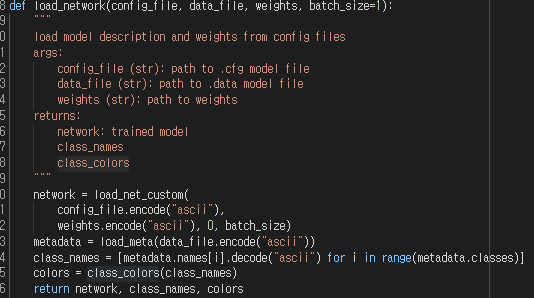

* darknet.py 파일을 확인해보면 load_network 함수의 1번째 인자는 config file, 2번째 인자는 data file, 3번째 인자는 weights에 해당하는 것을 알 수 있다.
* 또한 load_network 함수는 학습된 모델(=network), class 이름(=class names), class 별 고유 색상(=class colors)를 반환하는 것을 알 수 있다.
* class colors는 이후 boundary box를 이미지 위에 시각화할 때 사용할 색상이다.

In [ ]:
# class의 종류 예시
class_names

['mask', 'no-mask']

In [ ]:
# class color의 예시

class_colors['mask'], class_colors['no-mask']

((42, 255, 26), (119, 21, 254))

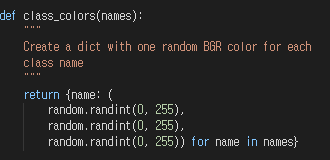

* 3가지의 값은 각각 B(Black), G(Green), R(Red)에 해당하는 것은 알 수 있다.
* 또한 색상은 랜덤하게 배정이 되었으며, 딕셔너리 형태로 클래스 별 생상 데이터가 저장되었음을 알 수 있다.
* 참고: OpenCV는 일반적인 RGB 순서가 아닌 BGR을 사용한다.

In [ ]:
# 네트워크의 width와 height을 계산
width = network_width(network)
height = network_height(network)

print(width, height)

416 416


`cv2.cvtColor(BGR이미지, cv2.COLOR_BGR2RGB)`

* 컬러 사진을 OpenCV에서는 BGR 순서로 인식하지만 일반적으로 matplotlib 등에서 사진을 출력하기 위하여는 이미지가 RGB 순서로 저장되어 있어야 한다.
* 따라서, 위와 같은 이유등을 위하여 이미지 순서를 RGB로 변환할 때 cvtColor을 사용한다.

`cv2.resize(이미지, dsize, fx, fy, interplolation)`
* 이미지의 크기를 조정한다.
* dsize는 결과 영상의 크기를 나타내며 (width, height)의 튜플 형태를 띈다.
* dsize가 (0,0)일 경우 fx와 fy를 통해 크기를 조정한다. fx와 fy는 스케일 비율을 나타낸다.
* interpolation은 보간법을 지정한다. 보간법은 이미지 확대 또는 축소 과정에서 이미지 픽셀의 유실이 일어났을 때, 주변 픽셀값을 이용하여 이를 채워넣는 방법을 의미한다. cv2.INTER_NEAREST,cv2.INTER_LINEAR, cv2.INTER_CUBIC 등이 있으며, INTER_LINEAR의 방법이 속도가 빠를 뿐더러 성능이 좋기 때문에 가장 많이 사용된다.

In [ ]:
# object detection을 수행하는 darknet_helper 함수를 살펴보자.

def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

* darknet_helper은 이미지 전처리(RGB로 변환, 크기 조정)부터 bounding box의 비율 계산, detection까지 모두 수행하는 함수이다.

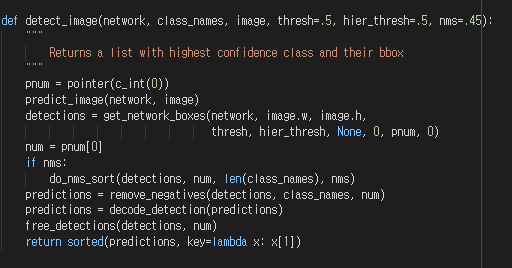

* derknet_helper에서 불러온 detect_image 함수를 더 자세히 살펴보자. 함수는 darknet.py에서 찾을 수 있다.
* detect_image는 이미지, netwok height, netwok width를 인자로 입력 받아1) bounding box와 2) 가장 높은 confidence를 가지는 클래스를 반환한다.

In [ ]:
%cd /content/darknet/data

/content/darknet/data


In [ ]:
# 파일 업로드 기능 실행
# files.upload()

`cv2.imread(이미지 경로, 모드)`
* 이미지를 BGR 형식으로 읽는 함수이다.
*  모드로는 IMREAD_UNCHAGNED (=원본), IMREAD_GRAYSCALE(=흑백), IMREAD_COLOR (=BGR 이미지), IMREAD_REDUCED_GRAYSCALE_2 (=2/1 크기의 흑백 이미지) 등이 있다. (기본 값 = IMREAD_UNCHAGED)


`matplotlib.pyplot.imshow(RGB 데이터 또는 2d scalaer 데이터)`

* imread() 함수를 사용하여 jpg 등 이미지 파일을 읽어온 후, imshow() 함수를 사용하여 이미지를 출력할 수 있다.


In [ ]:
!pwd

/content/darknet/data


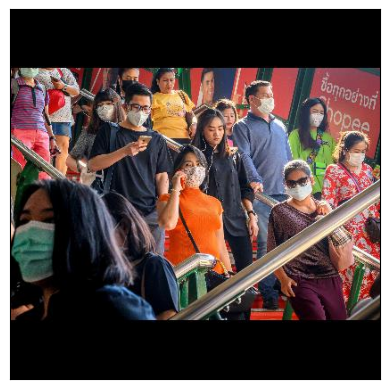

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/darknet/data/images/-1x-1_jpg.rf.8d697c00929e06e6655c08835cc66c02.jpg')
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(image)
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show()

## 5) YOLOv4 Example on Test Image
 모델이 성공적으로 load되었는지 샘플 이미지에 test하여보자.

In [ ]:
# darknet_helper 함수에 앞서 읽은 이미지와 network height, width를 입력
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

In [ ]:
# detection 결과 확인
detections

[('no-mask',
  '61.39',
  (174.5636444091797,
   81.26017761230469,
   23.972864151000977,
   28.40652084350586)),
 ('mask',
  '62.11',
  (174.01107788085938,
   81.95027923583984,
   27.423303604125977,
   27.77509117126465)),
 ('mask',
  '87.4',
  (240.5948486328125,
   118.06835174560547,
   22.757770538330078,
   42.494441986083984)),
 ('mask',
  '92.51',
  (20.789339065551758,
   73.57128143310547,
   28.358522415161133,
   15.373944282531738)),
 ('mask',
  '92.8',
  (132.93603515625, 76.94477844238281, 23.92178726196289, 22.071855545043945)),
 ('mask',
  '93.34',
  (54.20377731323242,
   249.25917053222656,
   87.46751403808594,
   114.7918472290039)),
 ('mask',
  '95.06',
  (142.3524932861328,
   105.74935913085938,
   38.55461502075195,
   53.27956771850586)),
 ('mask',
  '97.61',
  (225.0096893310547,
   132.3040313720703,
   34.810638427734375,
   48.02157211303711)),
 ('mask',
  '98.4',
  (321.9532775878906,
   190.26499938964844,
   37.568843841552734,
   45.09407424926758)

* 튜플 형태 ("클래스 이름", class confidence, bounding box)로 결과가 저장된 것을 확인할 수 있다.
* bounding box로 나온 4가지 수치는 center x, center y, width, height에 해당한다.

In [ ]:
width_ratio, height_ratio

(1.0, 0.9975961538461539)

`cv2.rectangle(image, start, end, color, thickness)`
* 이미지에 start와 end를 연결하는 사각형을 그린다.
* image는 사각형을 그릴 이미지를 입력하는 인자이다.
* start는 top-left corner의 좌표를 입력하는 인자이다.
* end는 bottom-right corner의 좌표를 입력하는 인자이다.

`cv2.putText(img, text, org, font, fontSacle, color)`
* 이미지에 text를 입력한다.
* text는 텍스트를 입력하는 인자이다.
* org는 테스트를 표시할 위치를 입력하는 인자로 문자열의 bottom-left corner 좌표를 입력한다.

In [ ]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

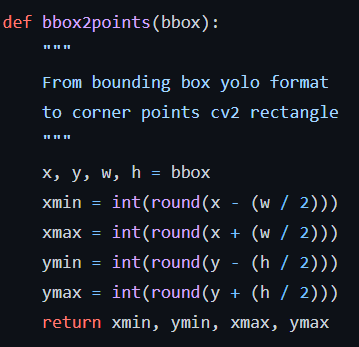

* center x, center y, width, height로 반환 받은 boundary box를 corner 정보로 변환하는 함수는 위와 같다.

## 6) Helper Functions : js_to_img, bbox_to_bytes

다양한 타입의 사진을 처리할 수 있도록 사용하는 helper function들을 생성하여보자.

* 웹캠을 구글 코랩에서 사용하기 위해서는 Javascript 코드를 실행하여야 한다. 따라서 OpenCV 파일을 Javascript 객체로 변환하고 그 반대로도 변환하는 함수를 생성하여 보자.
* 웹캠은 Javascript 코드를 사용하는 반면, bounding box는 OpenCV 형식이다.

`base64.b64decode(s, altchars=None, validate=False)`

* Base64로 인코딩된 바이트열류 객체나 ASCII 문자열 s를 디코딩하고 디코딩된 bytes를 반환한다.

In [ ]:
# JavaScript 객체를 OpenCV 이미지 유형으로 변환
def js_to_image(js_reply):
  """
  파라미터:
          js_reply: JavaScript 객체 (Base64 진법의 문자열)
  반환:
          img:  OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보)
  """

  # 64진법으로 인코딩된 Javascript 객체를 바이트로 디코딩
  image_bytes = b64decode(js_reply.split(',')[1])
  # 바이트를 넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

`.save(fp, format=None)`
* PIL 형식의 이미지를 저장한다.
* fp: 파일명/파일 주소/파일 객체
* format: 파일 저장 형식, 아무 입력이 없을 경우 파일명에 포함된 파일 형식으로 저장된다. fp에 파일명 대신 파일 객체가 입력되었을 경우 format 형식을 명시하는 것이 필수적이다.

In [ ]:
# OpenCV 사각형(Bounding Box) 이미지를 JavaScript 객체로 변환
def bbox_to_bytes(bbox_array):
  """
  파라미터:
          bbox_array: OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보)
  반환:
        바이트: JavaScript 객체 (Base64 진법의 문자열)
  """
  # 넘파일 배열을 PIL(Python Image Library) 이미지로 변환
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  # 문자열(바이트 배열)을 이진 파일로 읽을 수 있는 BytesIO 객체 생성
  iobuf = io.BytesIO()
  # PIL 이미지 형태의 boundary box를 png 파일로 변환하여 저장
  bbox_PIL.save(iobuf, format='png')
  # JavaScript 객체 반환
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## 7) YOLOv4 on Wecam Images

 웹캠으로 얻어진 이미지에 대하여 YOLO4을 적용하기 위하여, 구글 코랩에 있는 Code Snippets을 사용할 것이다. Code Snippets에는 다양한 작업을 위한 유용한 코드를 포함하고 있다.

 카메라 캡쳐 스니펫은 컴퓨터 웹캠을 사용하기 위한 자바스크립트 코드를 실행한다. 코드 스니펫은 웹캠 사진을 입력 받아 YOLOv4 model에 사진을 전달한다.

코드 스니펫

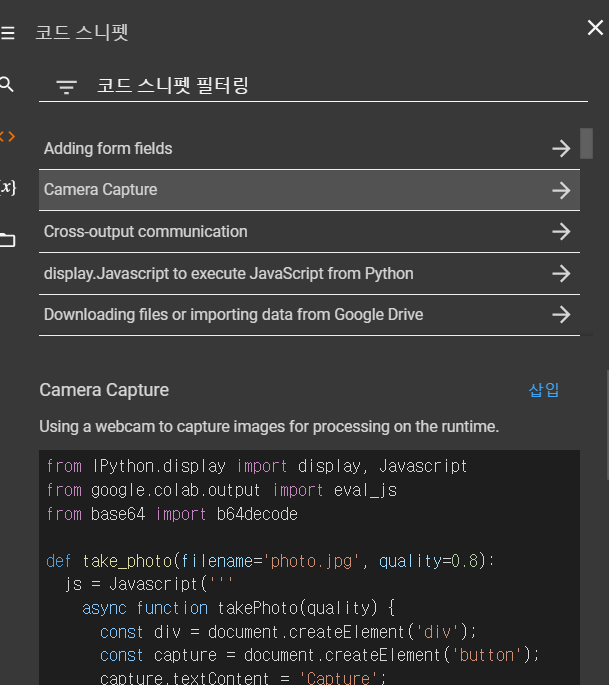

`eval_js()`
* 자바 스크립트 함수를 실행한다.
* 이를 통해 파이썬 내부에서 바로 사용할 수 있다.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):

  # 자바스크립트를 사용하여 local webcam에 access
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // 결과를 resize
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // 클릭하여 이미지 캡쳐
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # YOLO v4 detection 수행

  # javascrip 이미지를 입력
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV 형식의 이미지로 변환
  img = js_to_image(data)

  # 앞서 정의했던 darknet helper 함수에 웹캠 이미지를 삽입
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # detection을 통해 얻은 boundary boxes를 웹캠 이미지에 표시
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # 이미지를 저장
  cv2.imwrite(filename, img)

  return filename

* take_photo 실행 시 웹캠 권한을 묻는 메시지가 뜬다.

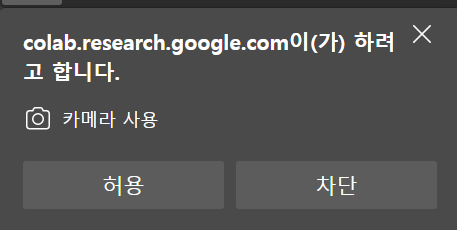

* 허용 버튼을 클릭하면 웹캠 이미지와 캡쳐 버튼이 생성된다.

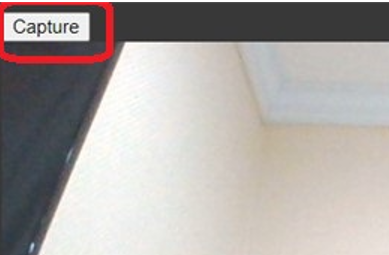

In [ ]:
try:
  # 앞서 정의한 take_photo 함수를 실행
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # take photo 결과물을 출력
  display(Image(filename))

  # 에러가 발행했을 실행
except Exception as err:
  # 사용자의 컴퓨터에 웹캠이 없거나 웹캠 접근권한이 없을 때 에러 메시지를 출력
  print(str(err))

## 8) YOLOv4 on Webcam Videos

앞선 단계에서 웹캠에서 얻은 이미지로 object detection을 수행하였다면, 이번에는 웹캠에서 실시간으로 얻어지는 영상에 YOLOv4을 사용하여보자.
실시간 영상의 각 프레임을 YOLOv4 모델에 통과시켜 bounding box를 생성하여 영상에 덧씌어 보자.


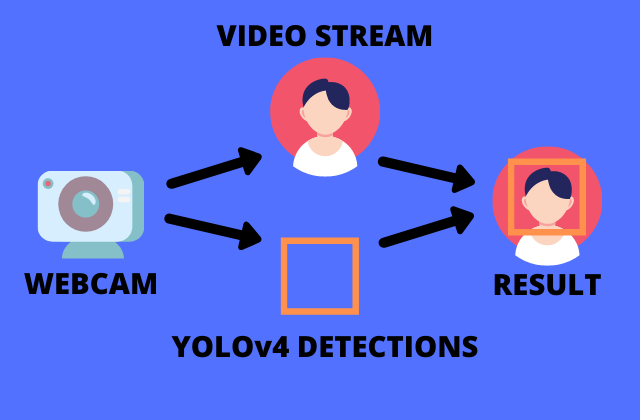



아래는 영상 스트리밍을 실행하는 자바스크립트 코드이다. 영상의 프레임은 YOLOv4의 입력으로 주어지게 된다.

In [ ]:
# 실시간 영상 스트리밍을 작동시키는 JavaScript 코드
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# 웹캠에서 영상 스트리밍을 시작
video_stream()
# label for video
label_html = 'Capturing...'
# bounding box 초기화
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # javascript 객체를 OpenCV 이미지로 변환
    frame = js_to_image(js_reply["img"])


    # bounding box를 위한 투명 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 앞서 정의하였던 darknet helper 함수를 실행
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # detection 결과를 순회하며 결과를 overlay 이미지에 표시
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bounding box의 overlay를 바이트로 변환
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bounding box를 업데이트하여 다음 프레임이 새로운 overlay를 갖도록 함
    bbox = bbox_bytes